# QOSF Task 4 Solution

SHAH ISHMAM MOHTASHIM, 
DEPARTMENT OF CHEMISTRY, UNIVERSITY OF DHAKA

Email: sishmam51@gmail.com

The given task 4 was
Finding the lowest eigenvalue of the following matrix:
 $$\begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{pmatrix}$$


using VQE-like circuits, from scratch.


# Solution

# Decomposition of Matrix





The matrix has to be decomposed as the sum of the tensor products of Pauli operators. The four Pauli matrices are:

I = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}
X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}
Y = \begin{pmatrix} 0 &-i \\ i & 0 \end{pmatrix}
Z = \begin{pmatrix} 1 & 0 \\ 0 &-1 \end{pmatrix}

The given matrix can be decomposed using the equations:

 $H = \sum_{i,j=1,x,y,z} a_{i,j} \left( \sigma_i \otimes \sigma_j \right),
\quad$
 $a_{i,j} = \frac{1}{4} tr \left[\left( \sigma_i \otimes \sigma_j \right) H \right]$


Reference- https://michaelgoerz.net/notes/decomposing-two-qubit-hamiltonians-into-pauli-matrices.html

The decomposition is implemented in code below:

In [35]:
from qiskit import *
import numpy as np 
from numpy import kron


Reference for the docomposition function: https://michaelgoerz.net/notes/decomposing-two-qubit-hamiltonians-into-pauli-matrices.html

In [36]:
def HS(M1, M2):
    """Hilbert-Schmidt-Product of two matrices M1, M2"""
    return (np.dot(M1.conjugate().transpose(), M2)).trace()



def decompose(H):
    """Decompose Hermitian 4x4 matrix H into Pauli matrices"""
    from numpy import kron
    sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
    sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    id = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)
    S = [id, sx, sy, sz]
    labels = ['I', 'sigma_x', 'sigma_y', 'sigma_z']
    for i in range(4):
        for j in range(4):
            label = labels[i] + labels[j]
            a_ij = 0.25 * HS(kron(S[i], S[j]), H)
            if a_ij != 0.0:
                print(a_ij,'*' ,label, '+')

Constructing the given matrix M:

In [37]:
M = np.array([[1, 0, 0, 0], [0, 0, -1, 0], [0, -1, 0, 0], [0, 0, 0, 1]])



Decomposing we get

In [38]:
decompose(M)

(0.5+0j) * II +
(-0.5+0j) * sigma_xsigma_x +
(-0.5+0j) * sigma_ysigma_y +
(0.5+0j) * sigma_zsigma_z +


# The decomposed matrix is 
$(0.5+0j) * II +
(-0.5+0j) * XX +
(-0.5+0j) * YY +
(0.5+0j) * ZZ$





The decomposed matrix can be written as hamiltonian
H1+H2+H3+H4

# Construction of Ansatz

Ansatz is basically a trial wavefunction.
The ansatz we use is: (RX I) CX (HI) |00>, where angle in RX is the variational parameter. (Provided by the hints from the task document)


In [39]:
def ansatz(angle):
    ckt = QuantumCircuit(2) 
    ckt.h(0)
    ckt.cx(0, 1)
    ckt.rx(angle, 0)
  
    
    return ckt


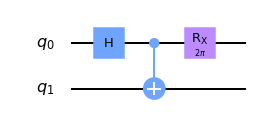

In [40]:
'''
Figure of Ansatz circuit
'''
ckt.draw(output='mpl')


# Conversion to Z basis
The only physical measurement that a quantum computer can do, is in the Z basis. Thus X and Y basis must be converted to Z basis before measurement.
1) For Y, $RX(π/2)$ rotation is needed.
2) For X, $RY(-π/2)$ rotation is needed

And the circuits for ZZ,XX,YY measurements are done accordingly
Reference: https://www.mustythoughts.com/variational-quantum-eigensolver-explained

# Circuit Preparation for ZZ

To meausre the expectation value for ZZ, rotations are not needed.


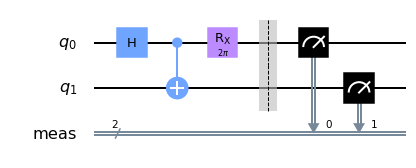

In [43]:
def zz_circuit(ckt):
    zz_measure = ckt.copy()
    zz_measure.measure_all()
    return zz_measure

zz_measure = zz_circuit(ckt)
zz_measure.draw(output='mpl')


# Circuit Preparation for XX


For X, $RY(-π/2)$ rotation is needed

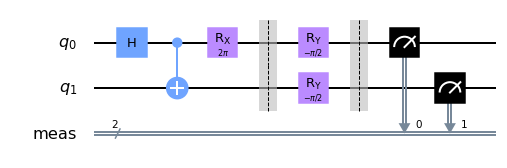

In [44]:
def xx_circuit(ckt):
    xx_measure = ckt.copy()
    
    '''
    Rotation by RY(-pie/2) for both qubits as shown by the figure of the circuit
    '''
    
    xx_measure.barrier()
    xx_measure.ry(-np.pi/2,0)
    xx_measure.ry(-np.pi/2,1)
    xx_measure.measure_all()
    
    return xx_measure

xx_measure = xx_circuit(ckt)
xx_measure.draw(output='mpl')

# Circuit Preparation for YY

For Y, $RX(π/2)$ rotation is needed

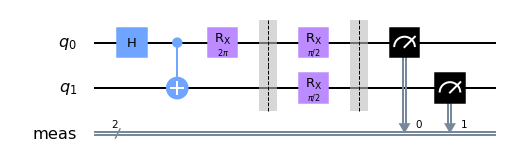

In [45]:
def yy_circuit(ckt):
    yy_measure = ckt.copy()
    '''
    Rotation by RX(pie/2) as shown by the figure of the circuit
    '''
    yy_measure.barrier()
    yy_measure.rx(np.pi/2, 0)
    yy_measure.rx(np.pi/2, 1)
    yy_measure.measure_all()
    
    return yy_measure

yy_measure = yy_circuit(ckt)
yy_measure.draw(output='mpl')

# Measurement of Expectation Values

To simulate the circuit for expectation values, qasm simulator is used.  The II term is added as a constant and no meausurement is necessary. 

For expactation values measured in ZZ, the values are calculated as
1 for 00 and 11 states and  -1 for 01 and 10 states. The values must be averaged over the total number of shots(=1024).






In [46]:
simulator = Aer.get_backend('qasm_simulator')


For ZZ meausrement:

In [47]:
def ZZ(ckt, shots = 1024):
    
    zz_measure = zz_circuit(ckt)
    
    result = execute(zz_measure, backend = simulator, shots = shots).result()
    
    
    '''
    (number of  ( 00 )  and (11) states measured) - (the number of (01) and (10) state measured )
    normalized over the number of shots
    00 and 11 has positive signs after application of ZZ gates and 01 and 10 has negative signs
    '''
    
    
    items =result.get_counts(zz_measure).items()
    
    s = 0
    for key, counts in items:
        s+= (-1)**(int(key[0])+int(key[1]))*counts
    
    s = s/shots
        
    return s

    print(s)
    

For XX measurement; The appropriate rotations has been completed before.

In [48]:
def XX(ckt, shots = 1024):
    
    xx_measure = xx_circuit(ckt)
    
    result = execute(xx_measure, backend = simulator, shots = shots).result()
    
    '''
    (number of  ( 00 )  and (11) states measured) - (the number of (01) and (10) state measured)
    normalized over the number of shots
    00 and 11 has positive signs after application of ZZ  and 01 and 10 has negative signs
    '''
    
    
    items =result.get_counts(xx_measure).items()
    
    s = 0
    for key, counts in items:
        s+= (-1)**(int(key[0])+int(key[1]))*counts
    
    s = s/shots
        
    return s
    
    

For YY measurement; The appropriate rotations has been completed before

In [49]:
def YY(ckt, shots = 1024):
    
    yy_measure = yy_circuit(ckt)
    
    result = execute(yy_measure, backend = simulator, shots = shots).result()
    
    
    
    '''
    (number of  ( 00 )  and (11) states measured) - (the number of (01) and (10) state measured)
    normalized over the number of shots
    00 and 11 has positive signs after application of ZZ  and 01 and 10 has negative signs
    '''
    
    items =result.get_counts(yy_measure).items()
    
    s = 0
    for key, counts in items:
        s+= (-1)**(int(key[0])+int(key[1]))*counts
    
    s = s/shots
        
    return s
    
  
   

# Function to evaluate the expectation value of Matrix M

In [50]:
def H(ckt, shots = 1024):
    
    zz = ZZ (ckt, shots=1024)
    xx = XX (ckt, shots=1024)
    yy = YY (ckt, shots=1024)
    
    E = 0.5*1 + (-0.5)*xx + (-0.5)*yy + 0.5*zz 
    '''
    All the individual pauli terms/decomposed hamiltonions are added up 
    '''
 
    
    return E

# Iteration till the lowest value is found

In [51]:
minimum_array=[]
minimum_energy = 100
for i in range(0, 361):
    ckt = ansatz(i*np.pi/180)
    energy = H(ckt) 
    minimum_array.append(energy)
    value = np.array(minimum_array)
    
    if (minimum_energy > energy):
        minimum_energy = energy

print("The lowest eigenvalue of the given matrix is",minimum_energy)

The lowest eigenvalue of the given matrix is -1.0


# Checking the minimum eigenvalue directly (Classical approach)

In [52]:
w = np.linalg.eigvals(M)
print(f'Lowest eigenvalue found classicaly is {min(w)}')

Lowest eigenvalue found classicaly is -1.0


# Plot of the results

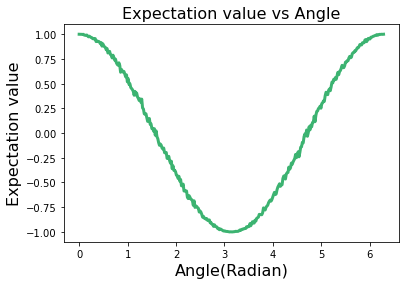

In [53]:
import matplotlib.pyplot as plt
angles = np.linspace(0.0, 2.0 * np.pi, 361)



plt.plot(angles, value, linewidth=3, color='mediumseagreen')
plt.xlabel('Angle(Radian)',fontsize=16)
plt.ylabel('Expectation value',fontsize=16)
plt.title('Expectation value vs Angle',fontsize=16)

plt.show()


